https://www.kaggle.com/search

In [358]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
plt.style.use('seaborn-whitegrid')

In [359]:
sales = pd.read_csv('Retail_Data_Transactions.csv')

In [360]:
sales.trans_date

0         11-Feb-13
1         15-Mar-15
2         26-Feb-13
3         16-Nov-11
4         20-Nov-13
            ...    
124995    26-Jun-11
124996    19-Aug-14
124997    28-Nov-14
124998    14-Dec-13
124999    13-Dec-14
Name: trans_date, Length: 125000, dtype: object

In [361]:
sales['trans_date'] = pd.to_datetime(sales['trans_date'])

In [362]:
print(max(sales.trans_date))
print(min(sales.trans_date))

2015-03-16 00:00:00
2011-05-16 00:00:00


In [363]:
sales =sales[sales.trans_date >= '2014-03-17']
sales.head()

,customer_id,trans_date,tran_amount
1,CS4768,2015-03-15,39
5,CS5539,2014-03-26,81
7,CS5902,2015-01-30,89
14,CS5552,2014-12-29,78
18,CS3904,2014-07-20,103


In [364]:
snapshot = max(sales.trans_date) + dt.timedelta(days = 1)

In [365]:
# Calculate Recency, Frequency and Monetary value for each customer 
RFM = sales.groupby(['customer_id']).agg({
    'trans_date': lambda x: (snapshot - x.max()).days,
    'customer_id': 'count',
    'tran_amount': 'sum'})

# Rename the columns 
RFM.rename(columns={'trans_date': 'Recency',
                         'customer_id': 'Frequency',
                         'tran_amount': 'MonetaryValue'}, inplace=True)
RFM.head()

,Recency,Frequency,MonetaryValue
customer_id,,,
CS1112,62,4,251
CS1113,36,6,393
CS1114,33,5,315
CS1115,12,3,248
CS1116,204,4,286


In [366]:
# Segment the Recency, Frequency and Monetary value
R_score = pd.qcut(RFM['Recency'], q = 4, labels = range(4, 0, -1))
F_score = pd.qcut(RFM['Frequency'], q = 4, labels = range(1, 5))
M_score = pd.qcut(RFM['MonetaryValue'], q = 4, labels = range(1, 5))
RFM = RFM.assign(R_score=R_score.values, F_score=F_score.values, M_score=M_score.values)
RFM['RFM_Score'] = RFM[['R_score','F_score','M_score']].sum(axis=1)

# Define rfm_level function
def get_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
RFM['RFM_Level'] = RFM.apply(get_level, axis=1)

RFM.head()

,Recency,Frequency,MonetaryValue,R_score,F_score,M_score,RFM_Score,RFM_Level
customer_id,,,,,,,,
CS1112,62,4,251,2,2,2,6.0,Middle
CS1113,36,6,393,3,3,3,9.0,Middle
CS1114,33,5,315,3,2,3,8.0,Middle
CS1115,12,3,248,4,1,2,7.0,Middle
CS1116,204,4,286,1,2,2,5.0,Low


In [367]:
RFM.RFM_Score.value_counts().describe()

count     10.00000
mean     678.10000
std      106.85343
min      515.00000
25%      583.25000
50%      692.00000
75%      755.75000
max      819.00000
Name: RFM_Score, dtype: float64

In [368]:
# Return the size of each segment
rfm_level_agg = RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         140.5       2.6         145.2  2065
Middle       57.0       4.7         301.2  3057
Top          28.9       7.6         532.2  1659


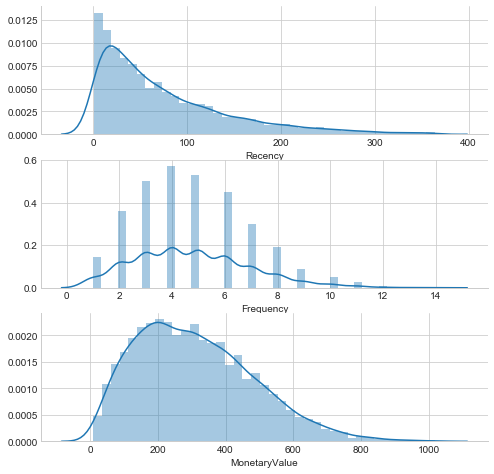

In [369]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(3, 1, figsize=(8, 8)); 
sns.despine(left=False, bottom=False)
sns.distplot(RFM['Recency'], ax=ax[0])
sns.distplot(RFM['Frequency'], ax=ax[1])
sns.distplot(RFM['MonetaryValue'], ax=ax[2])
plt.show()

In [371]:
# Unskew the data
RFM_log = np.sqrt(RFM.iloc[:, 0:3])

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(RFM_log)

# Scale and center the data
RFM_s = scaler.transform(RFM_log)

# Create a pandas DataFrame
RFM_s_df = pd.DataFrame(data=RFM_s, 
                     index=RFM.index, 
                     columns=RFM.iloc[:, 0:3].columns)
RFM_s_df.head()

,Recency,Frequency,MonetaryValue
customer_id,,,
CS1112,0.029382,-0.233272,-0.200390
CS1113,-0.448994,0.633499,0.582403
CS1114,-0.514200,0.221949,0.174222
CS1115,-1.096330,-0.749970,-0.219062
CS1116,1.665361,-0.233272,0.009710


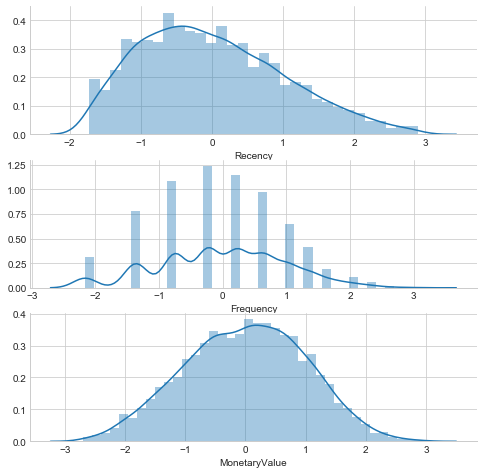

In [377]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8)); 
sns.despine(left=False, bottom=False)
sns.distplot(RFM_s_df['Recency'], ax=ax[0])
sns.distplot(RFM_s_df['Frequency'], ax=ax[1])
sns.distplot(RFM_s_df['MonetaryValue'], ax=ax[2])
plt.show()

In [378]:
# Initialize first KMeans with k = 3
kmeans = KMeans(n_clusters=3, random_state=5) 

# Fit k-means clustering on the normalized data set
kmeans.fit(RFM_s)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
RFM_k3 = RFM.assign(Cluster_3=cluster_labels)

# Group the data by cluster
# Calculate average RFM values and segment sizes per cluster value
RFM_k3_agg = RFM_k3.groupby(['Cluster_3']).agg({'Recency': 'mean', 
                                           'Frequency': 'mean', 
                                           'MonetaryValue': ['mean', 'count']
                                          }).round(1)


print(RFM_k3_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
Cluster_3                                      
0            50.3       4.1         253.0  2834
1           161.9       2.4         138.3  1642
2            45.1       7.2         502.9  2305


In [379]:
# Create the Scree plot and compute the silhouette_score for optimal K
sse = {}
silhouette_avg = {}
# Fit KMeans and calculate SSE for each k
for k in range(2, 15):
  
    # Initialize KMeans with k clusters and fit KMeans on the normalized dataset
    kmeans = KMeans(n_clusters=k, random_state=1).fit(RFM_s)
    preds = kmeans.predict(RFM_s)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

    # The silhouette_score gives the average value for all the data.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg[k] = silhouette_score(RFM_s, preds)

print(sse)
a = [(k,v) for k, v in sorted(silhouette_avg.items(), key=lambda x: x[1]), reverse = True]
print(a)

SyntaxError: invalid syntax (<ipython-input-379-361481ba62bc>, line 20)

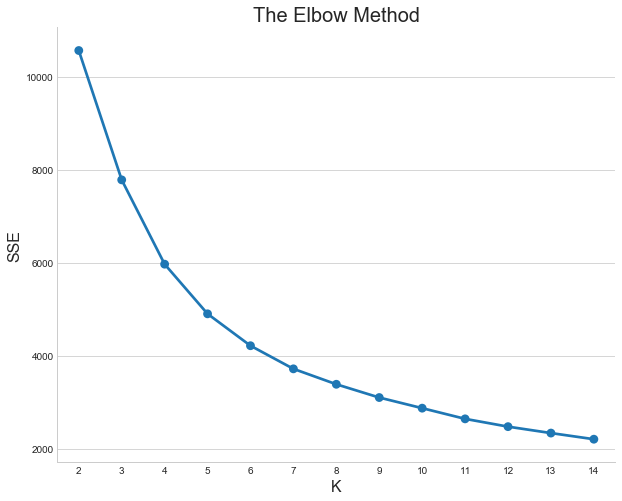

In [380]:
fig, ax = plt.subplots(1, figsize=(10, 8))
sns.despine(left=False, bottom=False)
# Add the plot title "The Elbow Method"
ax.set_title('The Elbow Method', fontsize = 20)

# Add X-axis label "k"
ax.set_xlabel('K', fontsize = 16)

# Add Y-axis label "SSE"
ax.set_ylabel('SSE', fontsize = 16)

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

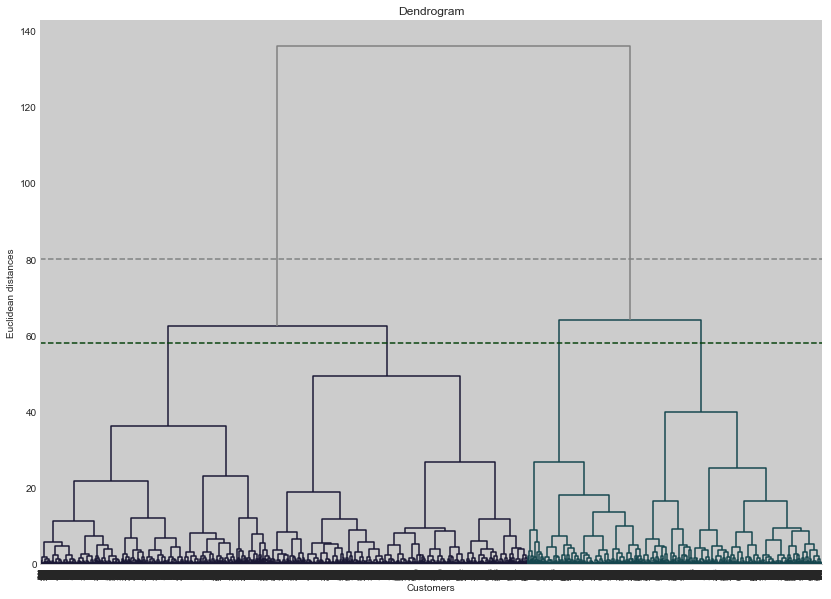

In [283]:
plt.style.use('seaborn-whitegrid')
cmap_den = sns.color_palette("cubehelix", 8).as_hex()
sch.set_link_color_palette(list(cmap_den))

plt.figure(figsize=(14, 10))
dendrogram = sch.dendrogram(sch.linkage(RFM_s, method  = "ward"), 
                            above_threshold_color = 'gray')
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.axhline(y=80, color='#808282', linestyle='--')
plt.axhline(y=58, color='#08420D', linestyle='--')
sns.despine(left=False, bottom=False)
plt.show()

In [309]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(RFM_s)

array([0, 3, 0, ..., 1, 1, 2])

In [179]:
# Initialize KMeans with k = 2
kmeans = KMeans(n_clusters=2, random_state=5) 

# Fit k-means clustering on the normalized data set
kmeans.fit(RFM_s)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
RFM_k2 = RFM.assign(Cluster_2=cluster_labels)

# Group the data by cluster
# Calculate average RFM values and segment sizes per cluster value
RFM_k2_agg = RFM_k2.groupby(['Cluster_2']).agg({'Recency': 'mean', 
                                           'Frequency': 'mean', 
                                           'MonetaryValue': ['mean', 'count']
                                          }).round(1)


print(RFM_k2_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
Cluster_2                                      
0            94.1       3.1         179.9  3530
1            55.4       6.5         451.7  3251


In [318]:
# Initialize KMeans with k = 4
kmeans = KMeans(n_clusters=4, random_state=5) 

# Fit k-means clustering on the normalized data set
kmeans.fit(RFM_s)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
RFM_k4 = RFM.assign(Cluster_4=cluster_labels)

# Group the data by cluster
# Calculate average RFM values and segment sizes per cluster value
RFM_k4_agg = RFM_k4.groupby(['Cluster_4']).agg({'Recency': 'mean', 
                                           'Frequency': 'mean', 
                                           'MonetaryValue': ['mean', 'count']
                                          }).round(1)


print(RFM_k4_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
Cluster_4                                      
0            31.2       3.6         209.3  1835
1           168.0       2.2         119.5  1306
2           107.8       5.0         332.5  1643
3            29.3       7.3         509.3  1997


In [319]:
RFM_s_df['Cluster_Label'] = cluster_labels
# Melt the normalized dataset and reset the index
RFM_s_melt = pd.melt(
  					RFM_s_df.reset_index(),     
                    id_vars = ['customer_id', 'Cluster_Label'],
                    value_vars = ['Recency', 'Frequency', 'MonetaryValue'], 
                    var_name = 'Metric', 
                    value_name = 'Value'
					)
RFM_s_melt

,customer_id,Cluster_Label,Metric,Value
0,CS1112,0,Recency,0.029382
1,CS1113,3,Recency,-0.448994
2,CS1114,0,Recency,-0.514200
3,CS1115,0,Recency,-1.096330
4,CS1116,2,Recency,1.665361
...,...,...,...,...
20338,CS8996,2,MonetaryValue,0.288668
20339,CS8997,1,MonetaryValue,-1.996469
20340,CS8998,0,MonetaryValue,-1.073623
20341,CS8999,1,MonetaryValue,-2.041193


In [315]:
RFM_s_df['RFM_Level'] = RFM['RFM_Level']
RFM_s_melt_quantiles = pd.melt(
  					RFM_s_df.reset_index(),     
                    id_vars = ['customer_id', 'RFM_Level'],
                    value_vars = ['Recency', 'Frequency', 'MonetaryValue'], 
                    var_name = 'Metric', 
                    value_name = 'Value'
					)
RFM_s_melt_quantiles

,customer_id,RFM_Level,Metric,Value
0,CS1112,Middle,Recency,0.029382
1,CS1113,Middle,Recency,-0.448994
2,CS1114,Middle,Recency,-0.514200
3,CS1115,Middle,Recency,-1.096330
4,CS1116,Low,Recency,1.665361
...,...,...,...,...
20338,CS8996,Middle,MonetaryValue,0.288668
20339,CS8997,Low,MonetaryValue,-1.996469
20340,CS8998,Low,MonetaryValue,-1.073623
20341,CS8999,Low,MonetaryValue,-2.041193


Text(0, 0.5, 'Value')

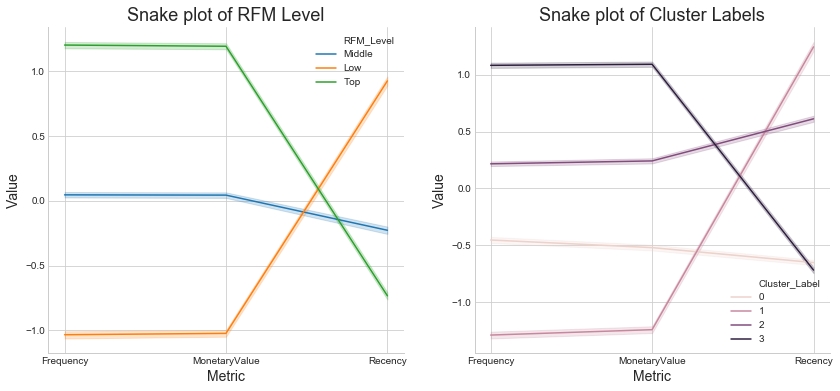

In [320]:
fig, ax = plt.subplots(1, 2, figsize=(14,6)) 
sns.lineplot(data=RFM_s_melt, x='Metric', y='Value', hue='Cluster_Label', ax = ax[1])
sns.despine(left=False, bottom=False)
ax[1].set_title('Snake plot of Cluster Labels', fontsize = 18)
ax[1].set_xlabel('Metric', fontsize = 14)
ax[1].set_ylabel('Value', fontsize = 14)

sns.lineplot(data=RFM_s_melt_quantiles, x='Metric', y='Value', hue='RFM_Level', ax = ax[0])
sns.despine(left=False, bottom=False)
ax[0].set_title('Snake plot of RFM Level', fontsize = 18)
ax[0].set_xlabel('Metric', fontsize = 14)
ax[0].set_ylabel('Value', fontsize = 14)



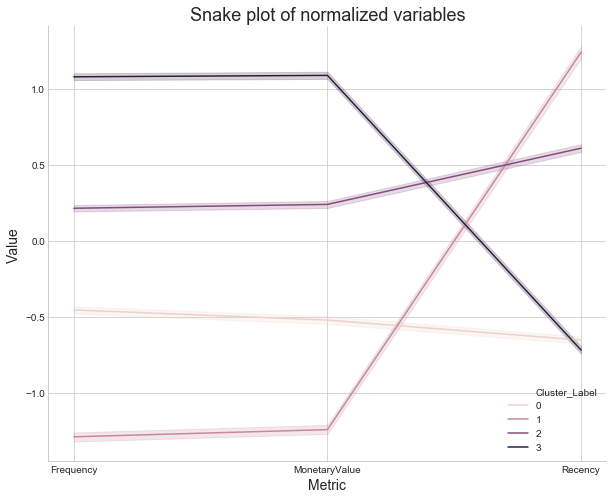

In [174]:
plt.figure(figsize=(10,8))
plt.title('Snake plot of normalized variables', fontsize = 18)
plt.xlabel('Metric', fontsize = 14)
plt.ylabel('Value', fontsize = 14)
sns.lineplot(data=RFM_s_melt, x='Metric', y='Value', hue='Cluster_Label')
sns.despine(left=False, bottom=False)
plt.show()

In [342]:
# Calculate relative importance of each attribute
# Calculate average RFM values for each cluster
RFM_k4_mean = RFM_k4.groupby(['Cluster_4'])['Recency', 'Frequency', 'MonetaryValue'].mean() 

# Calculate average RFM values for the total customer population
Overall_mean = RFM_k4_mean.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = RFM_k4_mean / Overall_mean - 1

# Print relative importance score rounded to 2 decimals
print(relative_imp.round(2))

           Recency  Frequency  MonetaryValue
Cluster_4                                   
0            -0.63      -0.20          -0.28
1             1.00      -0.52          -0.59
2             0.28       0.11           0.14
3            -0.65       0.60           0.74


In [347]:
# Calculate relative importance of each attribute
# Calculate average RFM values for each level
RFM_level_mean = RFM.groupby(['RFM_Level'])['Recency', 'Frequency', 'MonetaryValue'].mean() 

# Calculate average RFM values for the total customer population
Overall_mean = RFM_level_mean.mean()

# Calculate relative importance of level's attribute value compared to population
relative_imp_level = RFM_level_mean / Overall_mean - 1

# Print relative importance score rounded to 2 decimals
print(relative_imp_level.round(2))

           Recency  Frequency  MonetaryValue
RFM_Level                                   
Low           0.86      -0.47          -0.55
Middle       -0.24      -0.06          -0.08
Top          -0.62       0.53           0.63


Text(109.5, 0.5, 'Level')

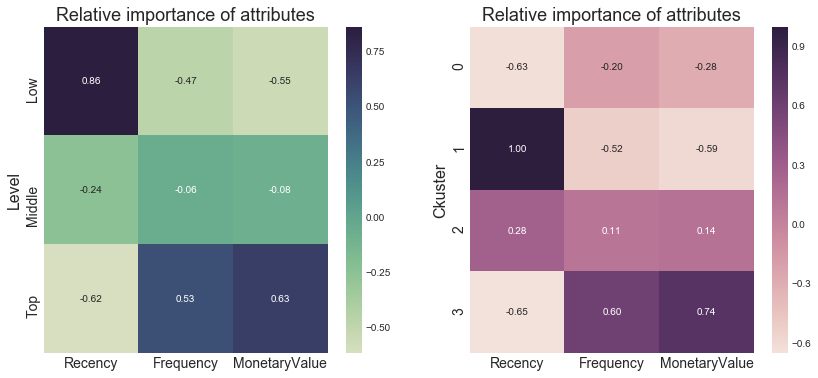

In [357]:
cmap = sns.cubehelix_palette(light=0.9, as_cmap=True)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap=cmap, ax=ax[1]) 
ax[1].set_title('Relative importance of attributes', fontsize=18)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].set_ylabel('Ckuster', fontsize=16)

cmap2 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
sns.heatmap(data=relative_imp_level, annot=True, fmt='.2f', cmap=cmap2, ax=ax[0]) 
ax[0].set_title('Relative importance of attributes', fontsize=18)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].set_ylabel('Level', fontsize=16)
